# Single Instrument Dashboard

## Setup AIA Inputs

### Import Statements

In [1]:
#%pip install astropy scipy ipympl ndcube xrtpy sunpy lxml drms zeep
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

from sys import path
import os, importlib, numpy as np, astropy.units as u, matplotlib as mpl, matplotlib.pyplot as plt
from astropy.time import Time
mpl.use("Agg")

# Enable interactive plotting with widgets
%matplotlib widget

# Set matplotlib parameters for better visualization
plt.rcParams.update({'image.origin': 'lower'})
np.set_printoptions(linewidth=128)

# Define base path and append EMToolKit path
base_path = os.getcwd(); path.append(base_path)

# import EMToolKit and its visualization module
import EMToolKit, EMToolKit.visualization.dashboard, EMToolKit.EMToolKit as emtk

# Initialize an empty EM collection
em_collection = 0

In [2]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False
recalc_sparse = True
recalc_simple = True

### Download the Imagery

In [3]:
from EMToolKit.instruments.aia import download_sdo_data

date='2010-07-25T17:58:44'

# Download the data
aia_paths, sdo_data_dir = download_sdo_data(os.path.join(base_path,'data','2010-07-25T17_58_44'), date, redownload=redownload)

Found 6 AIA images on disk.


### Load and Crop the Imagery

In [4]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
temperature_array = np.arange(5.5, 7.5, 0.05)
[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temperature_array=temperature_array)

In [5]:
# Make data sequence from AIA:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with data sequence:
em_collection = emtk.em_collection(datasequence)

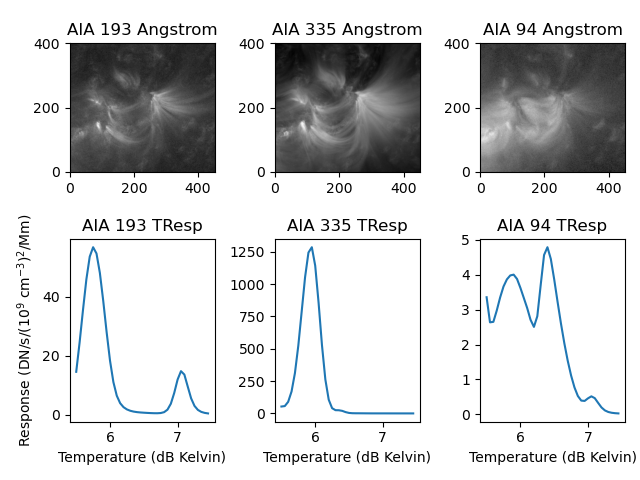

In [6]:
# Show some of the AIA channels and their temperature responses for illustration:

plt_emmax = 5.0e28  # Maximum emission value for plotting
gfac = 1.0 / 2.2  # Gamma correction factor for visualization

fig, axs = plt.subplots(2, 3)  # Create a figure with a 2x3 grid of subplots

# Plot AIA 193 Angstrom channel
axs[0, 0].imshow(np.clip(maps[1].data / np.max(tresps[1]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 0].set(title='AIA 193 Angstrom')
axs[1, 0].plot(trlogts[1], tresps[1] / 1.0e-27)
axs[1, 0].set(title='AIA 193 TResp', xlabel='Temperature (dB Kelvin)', ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

# Plot AIA 335 Angstrom channel
axs[0, 1].imshow(np.clip(maps[2].data / np.max(tresps[2]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 1].set(title='AIA 335 Angstrom')
axs[1, 1].plot(trlogts[2], tresps[2] / 1.0e-27)
axs[1, 1].set(title='AIA 335 TResp', xlabel='Temperature (dB Kelvin)')

# Plot AIA 94 Angstrom channel
axs[0, 2].imshow(np.clip(maps[5].data / np.max(tresps[5]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 2].set(title='AIA 94 Angstrom')
axs[1, 2].plot(trlogts[5], tresps[5] / 1.0e-27)
axs[1, 2].set(title='AIA 94 TResp', xlabel='Temperature (dB Kelvin)')

# Adjust layout and show the plots
plt.tight_layout(); plt.show()

## DEM Analysis

### Compute the Differential Emission Measure 

In [7]:
# Compute DEM for Plowman & Caspi simple_reg_dem method:
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm = simple_reg_dem_wrapper(datasequence)
simple_reg_demsequence = emtk.dem_model(simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm, simple_reg_dem_wrapper)
em_collection.add_model(simple_reg_demsequence) # Add DEM to collection

In [8]:
# Compute the DEM for Cheung et al. sparse EM method:
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm = sparse_em_wrapper(datasequence)
sparse_em_demsequence = emtk.dem_model(spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm, sparse_em_wrapper)
em_collection.add_model(sparse_em_demsequence) # Add DEM to collection

In [9]:
# Preliminary error estimation:
err_cube = em_collection.estimate_uncertainty(temperature_array)
print(err_cube.shape)

INFO:reproject.common:Calling _reproject_full in non-dask mode
INFO:reproject.common:Calling _reproject_full in non-dask mode
INFO:reproject.common:Calling _reproject_full in non-dask mode
INFO:reproject.common:Calling _reproject_full in non-dask mode
INFO:reproject.common:Calling _reproject_full in non-dask mode
INFO:reproject.common:Calling _reproject_full in non-dask mode


(402, 452, 40)


### Run the Dashboard

In [10]:
# Get the most recent version from the tool kit:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)

Output()

Click on the image to populate the dashboard


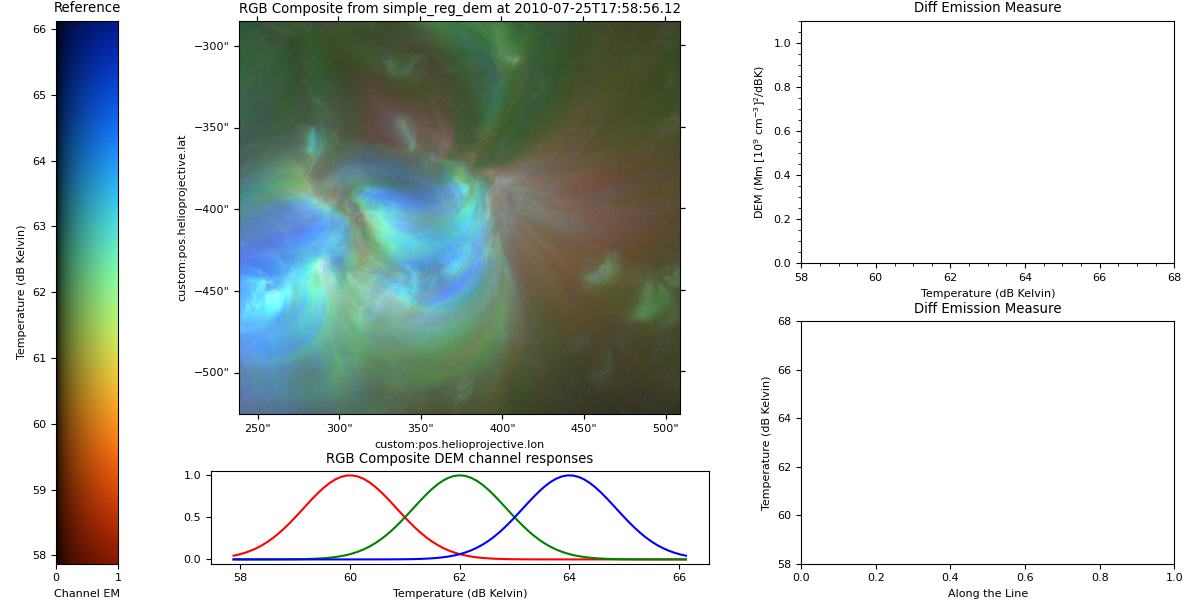

In [11]:
# Create the dashboard:
dash = dashboard_object(em_collection, xsize=12, ysize=6, fontsize=8)
dash.display(True)